* Compare technical analysis, methods are
    * MA
    * Bollinger band
    * MACD
    * RSI
    * Stochastics

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import mpl_finance
from scipy import stats
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
paths = glob.glob('./data/2017/*.txt')

col_names = ['code', 'name', 'open', 'high', 'low', 'close', 'volume']

# get code list
df_code = pd.read_csv(paths[0], delimiter='\t', encoding='SHIFT-JIS', header=None, names=col_names)
codes = df_code.iloc[1:, 0].as_matrix()

for path in tqdm(paths[1:]):

    df_code = pd.read_csv(path, delimiter='\t', encoding='SHIFT-JIS', header=None, names=col_names)
    codes = list(set(codes) & set(df_code.iloc[1:, 0].as_matrix()))
    
# code filtering
codes = np.array(codes)[np.array(codes) > 1700]

# get price data
df_all = pd.read_csv(paths[0], delimiter='\t', encoding='SHIFT-JIS', header=None, names=col_names)
date = str(df_all.iloc[0, 0])
date = date[:4] + '-' + date[4:6] + '-' + date[6:]
df_all['date'] = date
df_all = df_all.iloc[1:, :]
df_all = df_all[df_all['code'].isin(codes)]

for path in tqdm(paths[1:]):
    
    df = pd.read_csv(path, delimiter='\t', encoding='SHIFT-JIS', header=None, names=col_names)
    date = str(df.iloc[0, 0])
    date = date[:4] + '-' + date[4:6] + '-' + date[6:]
    df['date'] = date
    df = df.iloc[1:, :]
    df = df[df['code'].isin(codes)]
    df_all = pd.concat([df_all, df])

df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values(by=['code', 'date'], ascending=True)
print(len(df_all))

100%|██████████| 246/246 [00:14<00:00, 17.22it/s]


715806


In [3]:
c = 7203

start_date = '2017-01-01'
end_date = '2017-06-30'

* Set technical method functions.

In [4]:
# MAのゴールデンクロスによる買いシグナルの取得
def get_buy_signals_ma(df, ma_short_period=5, ma_long_period=25):
    
    avg_move_short = df['close'].rolling(ma_short_period).mean().values
    avg_move_long = df['close'].rolling(ma_long_period).mean().values

    cross = avg_move_short > avg_move_long
    golden =  np.array((cross != np.roll(cross, 1)) & (cross == True))
    
    return golden

In [5]:
# ボリンジャーバンドの-2σによる買いシグナルの取得
def get_buy_signals_bollinger(df, bollinger_period=25):
    
    avg_move = df['close'].rolling(bollinger_period).mean().values
    sigma = df['close'].rolling(bollinger_period).std(ddof=0).values

    sigma_minus2 = avg_move-sigma*2
    buy_signals = np.array(df['close'] < sigma_minus2)

    return buy_signals

In [6]:
# MACDのゴールデンクロスによる買いシグナルの取得
def get_buy_signals_macd(df, ema_short_period=12, ema_long_period=26, sma_period=9):

    macd = df['close'].ewm(span=ema_short_period).mean() - df['close'].ewm(span=ema_long_period).mean()
    signal = macd.rolling(sma_period).mean()

    cross = macd > signal
    golden =  np.array((cross != np.roll(cross, 1)) & (cross == True))
    
    return golden

In [7]:
# RSIによる買いシグナルの取得
def get_buy_signals_rsi(df, rsi_period=14, rsi_thresold=20):
    
    diff = df['close'].diff(1)
    positive = diff.clip_lower(0).ewm(alpha=1/rsi_period).mean()
    negative = diff.clip_upper(0).ewm(alpha=1/rsi_period).mean()
    rsi = 100-100/(1-positive/negative)

    buy_signals = np.array(rsi < rsi_thresold)

    return buy_signals

In [8]:
# ストキャスティクスのゴールデンクロスによる買いシグナルの取得
def get_buy_signals_stochastics(df, k_period=5, d_period=3, slowing_period=3):

    hline = df['high'].rolling(k_period).max()
    lline = df['low'].rolling(k_period).min()
    sumlow = (df['close']-lline).rolling(slowing_period).sum()
    sumhigh = (hline-lline).rolling(slowing_period).sum()
    stoch = sumlow/sumhigh*100
    signal = stoch.rolling(d_period).mean()

    cross = stoch > signal
    golden =  np.array((cross != np.roll(cross, 1)) & (cross == True) & (stoch < 20) & (signal < 20))
    
    return golden

* Evaluate mean and median using bootstrap method.

In [9]:
sampling_num = 100
holding_period = 20

In [10]:
# ブートストラップ信頼区間の計算
def calc_bootstrap_ci(data, bootstrap_num=1000, stat='mean'):
    
    stats = np.zeros((bootstrap_num), dtype=np.float32)
    
    for i in range(bootstrap_num):
        
        sample = np.random.choice(data, size=len(data))
        
        if stat == 'mean':
            stats[i] = np.mean(sample)
        elif stat == 'median':
            stats[i] = np.median(sample)
        
    mean = np.mean(stats)
    sd = np.std(stats)
    ci = (mean-1.96*sd, mean+1.96*sd)
    
    return mean, ci

In [11]:
# 各株価の推移
def plot_holding_period_prices(df, start_date, end_date, codes, sampling_num, holding_period, get_buy_signals_method):
    
    target_codes = np.random.choice(codes, size=sampling_num)
    target_codes_prices = np.empty((holding_period+1, 1), dtype=np.float32)
    
    plt.figure(figsize=(9, 3))
    
    for c in tqdm(target_codes):
        
        df_tmp = df[df['code'] == c]
        df_tmp = df_tmp[(start_date < df_tmp['date']) & (df_tmp['date'] < end_date)]
        
        buy_signals = get_buy_signals_method(df_tmp)
        
        base_closes = df_tmp['close'][buy_signals].as_matrix()
        prices = np.zeros((holding_period+1, len(base_closes)), dtype=np.float32)
        
        for d in range(holding_period+1):
            prices[d, :] = df_tmp['close'][np.roll(buy_signals, d)].as_matrix()/base_closes*100
    
        for r in prices.transpose():
            plt.plot(list(range(holding_period+1)), r, color='black', alpha=0.2)
        
        target_codes_prices = np.hstack((target_codes_prices, prices))
        
    plt.plot(list(range(holding_period+1)), [100]*(holding_period+1), color='r')

    plt.xticks(list(range(holding_period+1)))
    plt.xlim(0, holding_period)
    plt.ylim(80, 120)
    plt.xlabel('holding period')
    plt.ylabel('stock price (ratio)')
    plt.grid()
    plt.show()

    return target_codes_prices

# 各保有時点での株価の平均値/中央値とブートストラップ信頼区間
def plot_bootstrap_ci(target_codes_prices, holding_period, stat):
    
    prices_stat = np.zeros((holding_period+1), dtype=np.float32)
    prices_stat_ci_lower = np.zeros((holding_period+1), dtype=np.float32)
    prices_stat_ci_upper = np.zeros((holding_period+1), dtype=np.float32)
    
    for i, p in enumerate(target_codes_prices):
    
        s, ci = calc_bootstrap_ci(p, stat=stat)
        prices_stat[i] = s
        prices_stat_ci_lower[i] = ci[0]
        prices_stat_ci_upper[i] = ci[1]
    
    plt.figure(figsize=(9, 3))

    plt.plot(list(range(holding_period+1)), [100]*(holding_period+1), color='r')
    plt.plot(list(range(holding_period+1)), prices_stat, color='black', label=stat)
    plt.fill_between(list(range(holding_period+1)), prices_stat_ci_lower, prices_stat_ci_upper, color='black', alpha=0.2, label='confidence iterval')

    plt.xticks(list(range(holding_period+1)))
    plt.xlim(0, holding_period)
    plt.ylim(80, 120)
    plt.xlabel('holding period')
    plt.ylabel('stock price (ratio)')
    plt.legend()
    plt.grid()
    plt.show()

* Evaluate

100%|██████████| 100/100 [00:01<00:00, 62.95it/s]


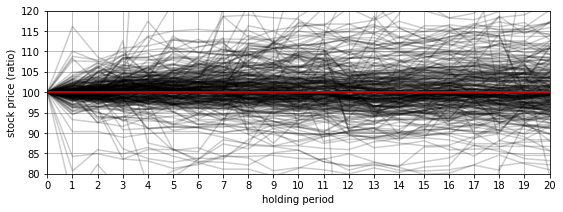

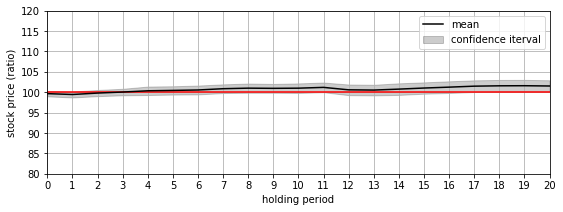

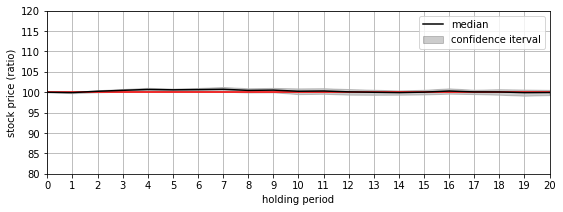

In [12]:
# MAの買いシグナルからの株価推移

# 各株価の推移
target_codes_prices = plot_holding_period_prices(
                                            df=df_all,
                                            start_date=start_date,
                                            end_date=end_date,
                                            codes=codes,
                                            sampling_num=sampling_num,
                                            holding_period=holding_period,
                                            get_buy_signals_method=get_buy_signals_ma
                                        )

# 各保有時点での株価の平均値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='mean')

# 各保有時点での株価の中央値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='median')

100%|██████████| 100/100 [00:01<00:00, 51.99it/s]


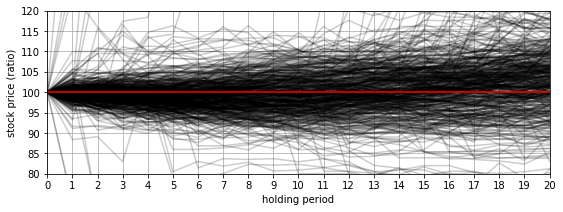

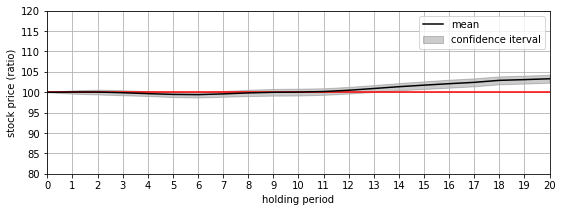

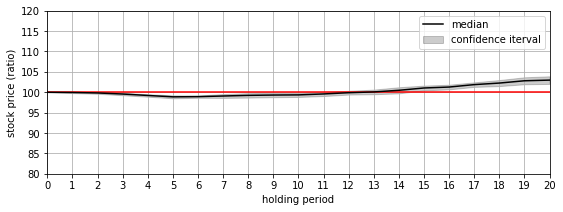

In [13]:
# ボリンジャーバンドの買いシグナルからの株価推移

# 各株価の推移
target_codes_prices = plot_holding_period_prices(
                                            df=df_all,
                                            start_date=start_date,
                                            end_date=end_date,
                                            codes=codes,
                                            sampling_num=sampling_num,
                                            holding_period=holding_period,
                                            get_buy_signals_method=get_buy_signals_bollinger
                                        )

# 各保有時点での株価の平均値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='mean')

# 各保有時点での株価の中央値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='median')

100%|██████████| 100/100 [00:02<00:00, 48.61it/s]


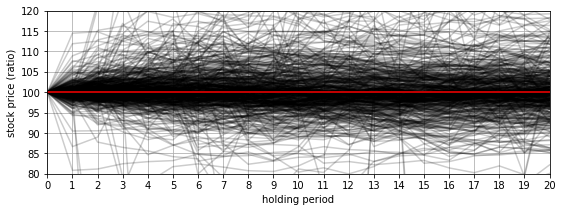

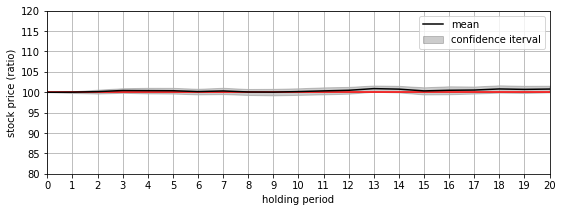

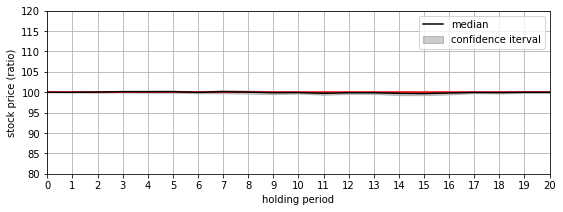

In [14]:
# MACDのゴールデンクロスからの株価推移

# 各株価の推移
target_codes_prices = plot_holding_period_prices(
                                            df=df_all,
                                            start_date=start_date,
                                            end_date=end_date,
                                            codes=codes,
                                            sampling_num=sampling_num,
                                            holding_period=holding_period,
                                            get_buy_signals_method=get_buy_signals_macd
                                        )

# 各保有時点での株価の平均値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='mean')

# 各保有時点での株価の中央値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='median')

100%|██████████| 100/100 [00:01<00:00, 63.61it/s]


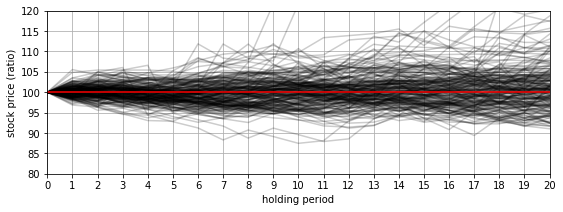

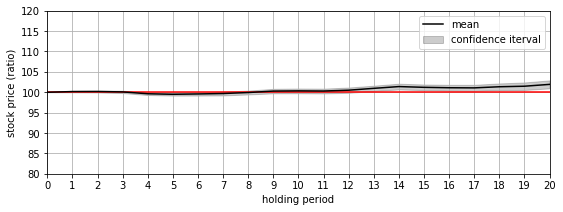

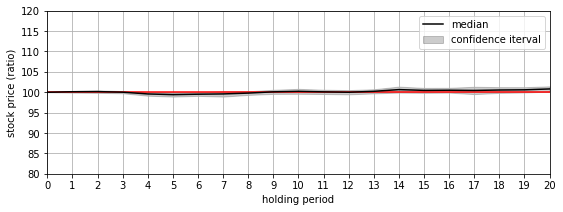

In [15]:
# RSIの買いシグナルからの株価推移

# 各株価の推移
target_codes_prices = plot_holding_period_prices(
                                            df=df_all,
                                            start_date=start_date,
                                            end_date=end_date,
                                            codes=codes,
                                            sampling_num=sampling_num,
                                            holding_period=holding_period,
                                            get_buy_signals_method=get_buy_signals_rsi
                                        )

# 各保有時点での株価の平均値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='mean')

# 各保有時点での株価の中央値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='median')

100%|██████████| 100/100 [00:01<00:00, 57.01it/s]


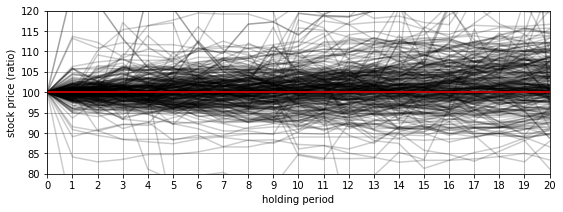

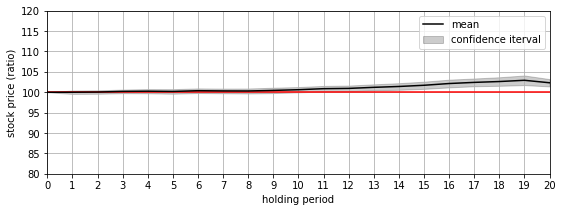

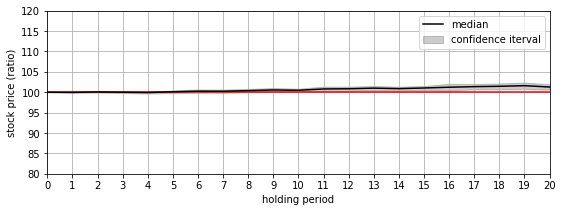

In [16]:
# ストキャスティクスの買いシグナルからの株価推移

# 各株価の推移
target_codes_prices = plot_holding_period_prices(
                                            df=df_all,
                                            start_date=start_date,
                                            end_date=end_date,
                                            codes=codes,
                                            sampling_num=sampling_num,
                                            holding_period=holding_period,
                                            get_buy_signals_method=get_buy_signals_stochastics
                                        )

# 各保有時点での株価の平均値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='mean')

# 各保有時点での株価の中央値とブートストラップ信頼区間
plot_bootstrap_ci(target_codes_prices, holding_period=holding_period, stat='median')